### I download this [Dataset](https://github.com/123harshil/Alcohol-Consumption-Analysis/blob/main/russian_alcohol_consumption.csv) here.

# Goal: Preferred area to run promotion a drink company
Our company owns a chain Of stores across Russia that sell variety of alcohol drinks. The company recently ran a wine promotion in St Petersburg That was very successful due to the coast to the business They haven't been so much money to run in all the regions The marketing team would like to target 10 other regions that are similar buying habit to send Petersburg where they would expect the promotion to be similarly successful.

## 1. The Datasets
Historical sales volume per capita for different drink types.

### 1.1 Key Variables
- "year" - year (1998-2016)
- "region" - name of a federal subject of Russia. It could be oblast, republic, krai, autonomous okrug, federal city and a single autonomous oblast
- "wine" - sale of wine in litres by year per capita
- "beer" - sale of beer in litres by year per capita
- "vodka" - sale of vodka in litres by year per capita
- "champagne" - sale of champagne in litres by year per capita
- "brandy" - sale of brandy in litres by year per capita
* Here, `per capita` (per person) is used to determine how certain metrics apply to a population.

In [1]:
# Import all necessary modules
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv(r'Data/russian_alcohol_consumption.csv')
print(df.shape)
df.head()

(1615, 7)


,year,region,wine,beer,vodka,champagne,brandy
0,1998,Republic of Adygea,1.9,8.8,3.4,0.3,0.1
1,1998,Altai Krai,3.3,19.2,11.3,1.1,0.1
2,1998,Amur Oblast,2.1,21.2,17.3,0.7,0.4
3,1998,Arkhangelsk Oblast,4.3,10.6,11.7,0.4,0.3
4,1998,Astrakhan Oblast,2.9,18.0,9.5,0.8,0.2


### 1.2 Handling missing values
#### Missing values identification

In [3]:
# cheak missing values
df.isna().sum()

year          0
region        0
wine         63
beer         58
vodka        61
champagne    63
brandy       66
dtype: int64

In [4]:
# Define segments
segments = ['wine', 'beer', 'vodka', 'champagne', 'brandy']

# Find the rows that have missing values in any of the segments columns
nan_count = df[df[segments].isnull().any(axis=1)]

# Add a column that counts the number of missing values per row
nan_count.loc[:, 'na_count'] = nan_count[segments].isnull().sum(axis=1)

# Create a pivot table that shows the total number of missing values per region and year, and fill the missing values with zero
nan_pivot = nan_count.pivot_table(index='region', columns='year', values='na_count', aggfunc='sum').fillna(0)
nan_pivot

C:\Users\nikey\AppData\Local\Temp\ipykernel_4080\231543705.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nan_count.loc[:, 'na_count'] = nan_count[segments].isnull().sum(axis=1)


year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
region,,,,,,,,,,,,,,,,,,,
Chechen Republic,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,4.0
Republic of Crimea,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,0.0,0.0,0.0
Republic of Ingushetia,5.0,5.0,5.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,5.0,4.0,4.0,5.0,5.0,5.0,4.0,4.0,5.0
Sevastopol,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,0.0,0.0,0.0


#### Handling missing values
Based on the counts above, it would make sense to completely drop regions with most of the data missing - Chechen Republic, Republic of Crimea, Republic of Ingushetia and Sevastopol as it's only 4 region

~ is means Bitwise NOT

In [5]:
print(df.shape)
df = df[~df.region.isin(nan_pivot.index.to_list())]
print(df.shape)

(1615, 7)
(1539, 7)


## 2. Analysis plan
The project is about identifying pattern is unlabelled dataset which we would called it **unsupervised ML** and since we need to find particular region near it **clustering** Appears to be a powerful candidate/choice of the model. Here, the **size of dataset is relatively small, hierarchical clustering** can consider method of choice.

Once we complete clustering, we will need to rank the regions from the same cluster as Saint Petersburg to select top 10. To be able to do to the ranking successfully, we need to have a good understanding of what makes Saint Petersburg different from other regions. This will allow us to to prioritize the regions in the optimal way.

## 3. EDA
### Data Preparation Code

In [6]:
# Add total alc consumption
df['total_alc'] = df.apply(lambda x: x.wine + x.beer + x.vodka + x.champagne + x.brandy, axis=1)

# Add consumption as share of total
segments_shr = [s + '_shr' for s in segments]
for s in segments:
    df[s + '_shr'] = df.apply(lambda x: x[s] / x.total_alc, axis=1)

# Subset Sain Petersburg
spb_df = df[df['region'] == 'Saint Petersburg'].set_index('year')

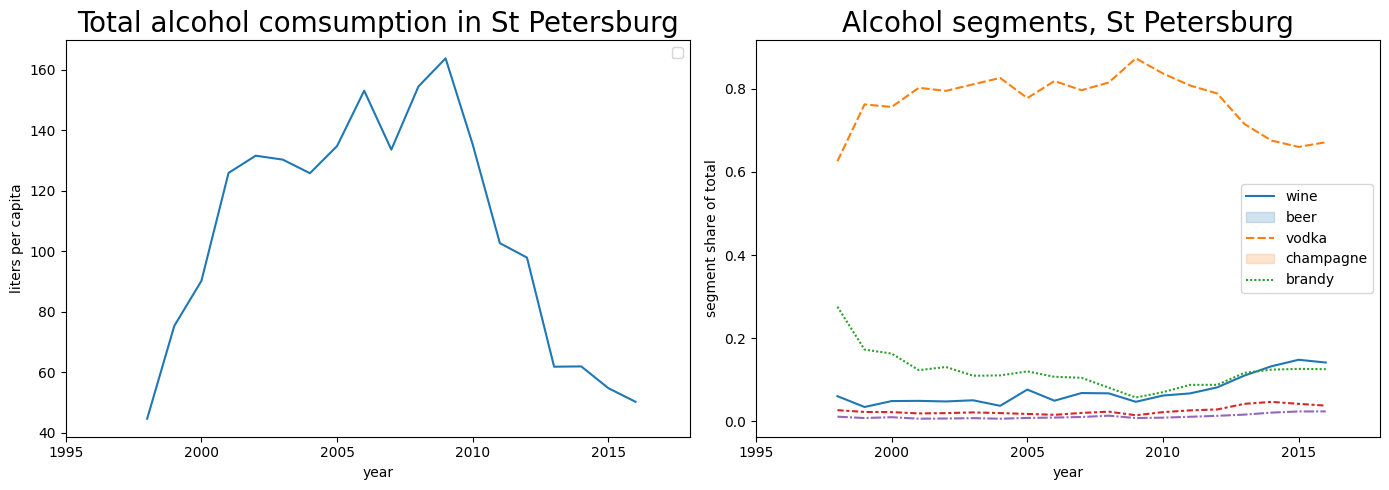

In [7]:
# Set up charting function
def spb_charts():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 5), tight_layout=True)
    sns.lineplot(data=spb_df['total_alc'], ax=ax1)
    ax1.set_title('Total alcohol comsumption in St Petersburg', fontsize=20)
    ax1.set(
        xlabel = 'year', 
        ylabel = 'liters per capita',
        xlim = (1995, 2018)
    )
    ax1.legend('')
    
    sns.lineplot(data=spb_df[segments_shr], ax=ax2)
    ax2.set_title('Alcohol segments, St Petersburg', fontsize=20)
    ax2.set(
        xlabel = 'year',
        ylabel = 'segment share of total',
        xlim = (1995, 2018)
    )
    ax2.legend(['wine', 'beer', 'vodka', 'champagne', 'brandy'])
    plt.show()
spb_charts()

##### Conclusions
- Overall alcohol consumtion peaked in 2010 and steadily declined after dropping back to initial stage.
- Beer represents the highest share of all segments and was the controls of peak and decline
- Wine share of alcohol consumption has been steadily growing across observed period while other segments were mostly flat.

*Now let's compare these trends with national (overall to that particular company) averages.*

### 3.2 Alcohol consumption trends in St Petersburg vs. National averages.
Data Manipulation Code

In [8]:
# Set up comparisons
segs = segments + ['total_alc']
subset = pd.DataFrame()

def seg_series(reg='nat', s='total_alc'):
    """Returns pandas series with national average or Saint Petersburg for segment s
    Args:
        reg: input for region, nat or spb
        s:   segment to select (can be total_alc)
    """
    if reg == 'spb':
        subset = df[df['region'] == 'Saint Petersburg']
    else:
        subset = df
    if s == 'total_alc':
        return subset.groupby(by='year')[s].mean()
    return subset.groupby(by='year')[s+'_shr'].mean()*100 # Turn into %

for s in segs:
    # National average
    subset['nat_' + s] = seg_series(s=s)
    # Spb 
    subset['spb_' + s] = seg_series(reg='spb', s=s)

lbls = ['National', 'St Petersburg']

def spb_vs_nat_charts():
    """Plots the charts comparing Spb to National average"""
    fig, axes = plt.subplots(2, 3, figsize=(14, 8), tight_layout=True)
    for s, ax in zip(segs, axes.flatten()):
        sns.lineplot(ax=ax, data=subset[['nat_'+s, 'spb_'+s]])
        if s == 'total_alc':
            ax.set_title('Alcohol consumption, liters per capita')
        else:
            ax.set_title(s.title() + ' as % of alcohol')
        ax.set(
            xlabel = 'year',
            xlim = (1995, 2018)
        )
        ax.legend(lbls)
    plt.show()

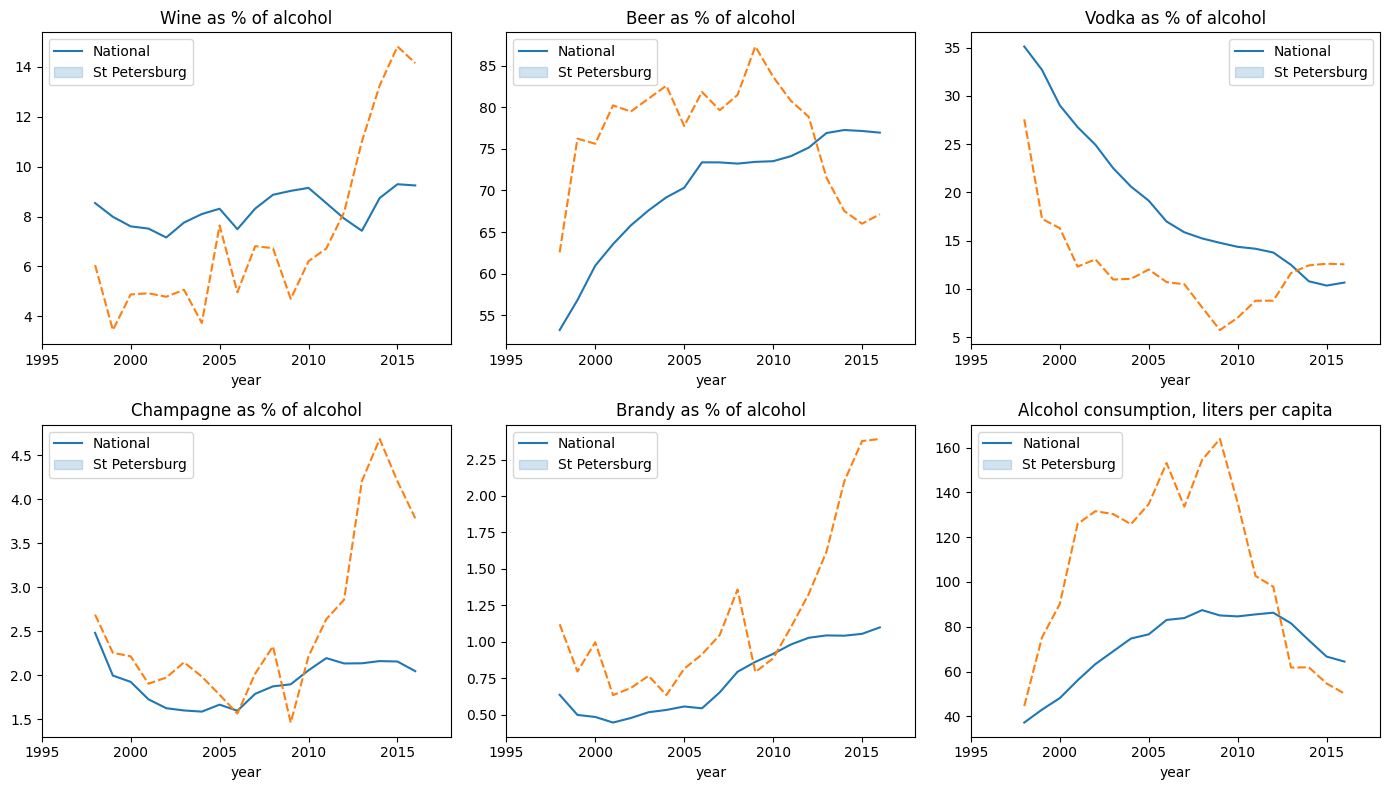

In [9]:
spb_vs_nat_charts()

#### Conclusions
Saint Petersburg appears to show a significant trend differences vs. national average starting from year 2010 onwards. The segments that show vastly different dynamics are:
- **Wine as % of alcohol** - significantly faster **consumption share growth** trend from 2010 surpassing national average. 
- **Beer as % of alcohol** - sharp drop from 2010 and dropping below national average (which is still growing). It's worth noting that beer was the primary driver of alcohol consumption in Saint Petersburg and was largely responsible for this region being 1.5x higher compared to national during 2000-2009 decade, but after that consumption started shifting from beer to other segments indicating consumer preference for variety.
- **Vodka as % of alcohol** - after following national decline trend until 2010, it started growing again surpassing national average.
- **Champagne and Brandy as % of alcohol** - show similarly fast growth pattern starting from 2010 and reaching doubled the share compared to national average.

**Bottom line**   
Consumers in Saint Petersburg region reduced overall alcohol consumption faster than national, at the same time the market shares shifted significantly between different types of alcohol. Hence we need to focus not only on absolute shares of different segments, but also the dynamics starting from 2010 onwards in our feature selection for clustering.
    
**Note: we're looking into shares of segments on the background of significant overall consumption decline. In this context the share growth doesn't mean absolute growth in liters per capita.**

In [19]:
# Key constants
ema_span = 15
ema_span_shr_chg = 5 # To focus on the last few years 
idx = df.year.max()

# Set up features dataframe and add wine per capita
gb_reg = df.set_index('year').groupby('region')
features_df = gb_reg[['wine']].ewm(span=ema_span).mean().unstack('year')
# print(features_df)
features_df = features_df[[('wine', idx)]].droplevel('year', axis=1)
# features_df

# Add segment shares
for s in segments_shr:
    data = gb_reg[[s]].ewm(span=ema_span).mean().mul(100).unstack('year')
    features_df[s] = data[[(s, idx)]].droplevel('year', axis=1)
# features_df

# Add segment share change dynamics - share point change difference
# Subset the original data and get exponential average of the difference
data = df[['year', 'region'] + segments_shr].groupby(by=['region', 'year']).mean().mul(100).diff()
data = data.groupby(by='region').ewm(span=3).mean().droplevel(0)

# Add each feature
for s in segments_shr:
    features_df[s + '_ptchg'] = data[[s]].unstack('year')[[(s, idx)]].droplevel('year', axis=1)

In [22]:
features_df.sort_values('wine_shr', ascending= False).head()

,wine,wine_shr,beer_shr,vodka_shr,champagne_shr,brandy_shr,wine_shr_ptchg,beer_shr_ptchg,vodka_shr_ptchg,champagne_shr_ptchg,brandy_shr_ptchg
region,,,,,,,,,,,
Mari El Republic,7.910013,15.105553,60.628615,21.719934,1.695979,0.849919,-1.218593,2.314155,-0.929322,-0.213415,0.047175
Pskov Oblast,10.600907,14.892274,67.802847,14.340541,2.078613,0.885725,1.705219,-1.692219,-0.281060,0.086442,0.181617
Republic of Karelia,11.736149,14.882670,62.631417,19.589758,1.666937,1.229218,0.344304,-0.113553,-0.253315,-0.041838,0.064403
Novgorod Oblast,10.911511,14.669453,65.010205,17.114121,2.148761,1.057460,0.127955,0.688998,-0.654337,-0.172050,0.009434
Republic of Dagestan,1.832973,13.416803,29.440830,49.361679,4.170037,3.610650,-3.248583,-4.723330,6.219295,0.310841,1.441777


## 5. Clustering Implementation
### Key Considerations
Our data set is small, so hierarchical clustering won't be computationally too expensive and will give us a good idea of how tight the cluster is for our region of interest. The following tools and considerations are important for our model:
- **Feature scaling** to make sure different scale of features doesn't introduce bias into clustering
- **Using dendrogram (map of clusters)** will give us an important visualization of the cluster that includes Saint Petersburg region
- **Using t-distributed stochastic neighbor embedding (t-SNE) for 2-dimensional visual** can give us a sense how tight the cluster is and the overall feature variable space
- **Principal Component Aanalysis (PCA)** can give us another take on reducing the dimensionality of feature space and can potentially introduce another take on clustering when we use PCA components as features.

In [23]:
# Import modules for scaling and hierarchical clustering
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
import matplotlib.patches as patches

In [24]:
# Scaling features
scaled_features = pd.DataFrame(StandardScaler().fit_transform(features_df), 
                               index=features_df.index, columns=features_df.columns)

# Clustering
Z = linkage(scaled_features, method='complete')

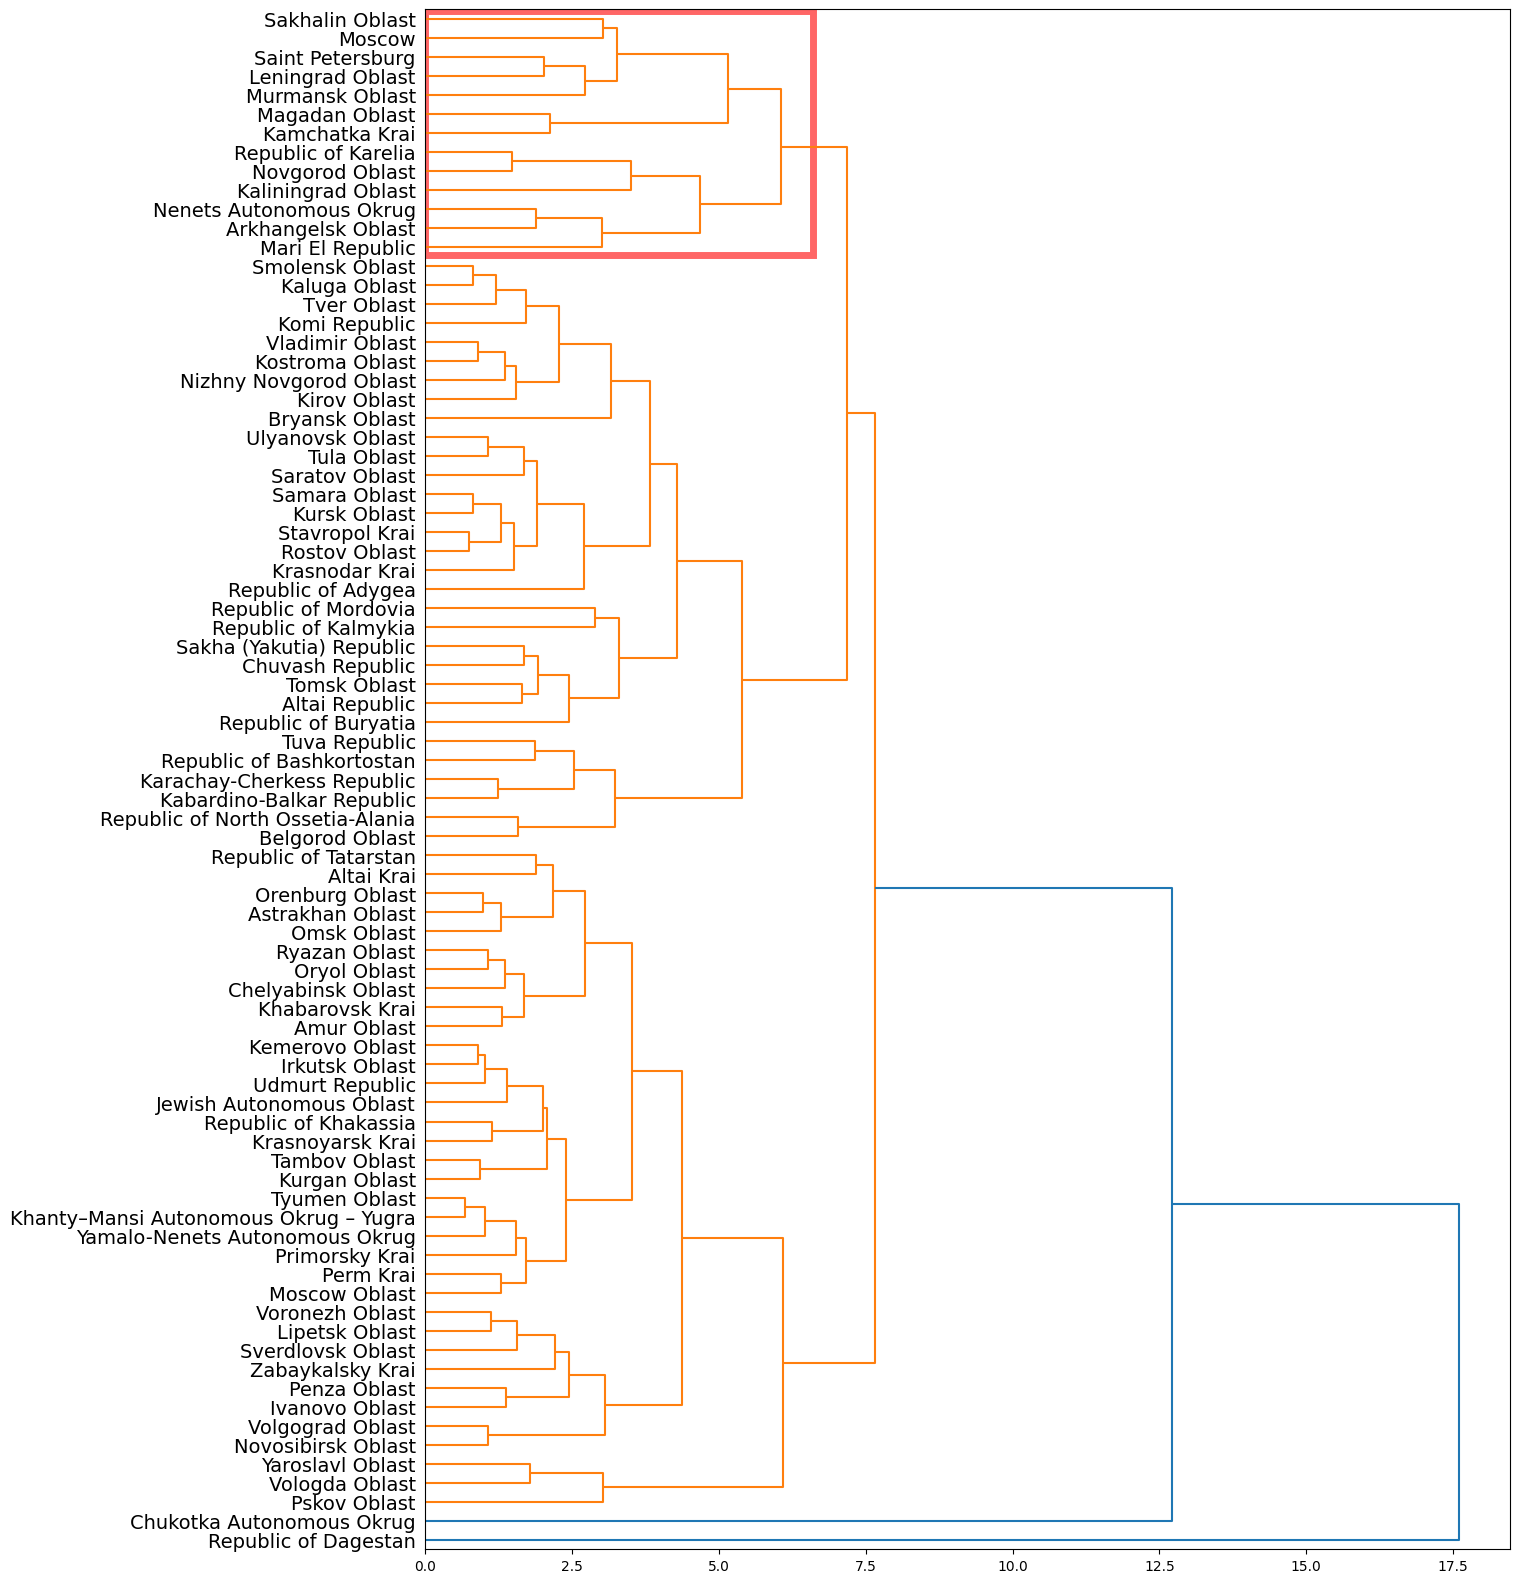

In [25]:
# Visualize Dendrogram and find same patter as in Saint Petersburg
fig, ax = plt.subplots(figsize=(14, 20))
dn = dendrogram(Z, labels=features_df.index, orientation='right',
                leaf_rotation=0, leaf_font_size=14)
rect = patches.Rectangle((0, 809.0), 6.6, -128.0, linewidth=5, edgecolor='r', 
                         fill=False, facecolor=None, alpha=0.6)
ax.add_patch(rect)
plt.show()

In [27]:
# Cluster labers of interest
features_df['cluster'] = fcluster(Z, 5, criterion='maxclust')
spb_cluster = features_df.loc['Saint Petersburg', 'cluster']
output = features_df[features_df.cluster == spb_cluster]
output.tail()

,wine,wine_shr,beer_shr,vodka_shr,champagne_shr,brandy_shr,wine_shr_ptchg,beer_shr_ptchg,vodka_shr_ptchg,champagne_shr_ptchg,brandy_shr_ptchg,cluster
region,,,,,,,,,,,,
Nenets Autonomous Okrug,10.281473,13.174027,61.834055,20.618339,3.017646,1.355932,-0.290969,1.951142,-1.489519,-0.056255,-0.114398,3
Novgorod Oblast,10.911511,14.669453,65.010205,17.114121,2.148761,1.057460,0.127955,0.688998,-0.654337,-0.172050,0.009434,3
Republic of Karelia,11.736149,14.882670,62.631417,19.589758,1.666937,1.229218,0.344304,-0.113553,-0.253315,-0.041838,0.064403,3
Saint Petersburg,7.556872,9.425069,74.899617,11.065619,3.092032,1.517664,0.573718,-0.881005,0.312295,-0.169210,0.164202,3
Sakhalin Oblast,7.336412,8.195291,67.114749,19.941569,3.437766,1.310624,0.594852,-1.880275,0.970498,0.147772,0.167152,3


In [ ]:
# Doing t-SNE
# --- Here is code --- #

In [30]:
# Doing PCA
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(scaled_features)

pca_features = pd.DataFrame(index= range(pca.n_components_))
pca_features.index.name = 'PCA component'
pca_features['Exp. Variance'] = pca.explained_variance_
pca_features.head()

,Exp. Variance
PCA component,
0,4.412964
1,3.120773
2,1.674092
3,0.851549
4,0.402341


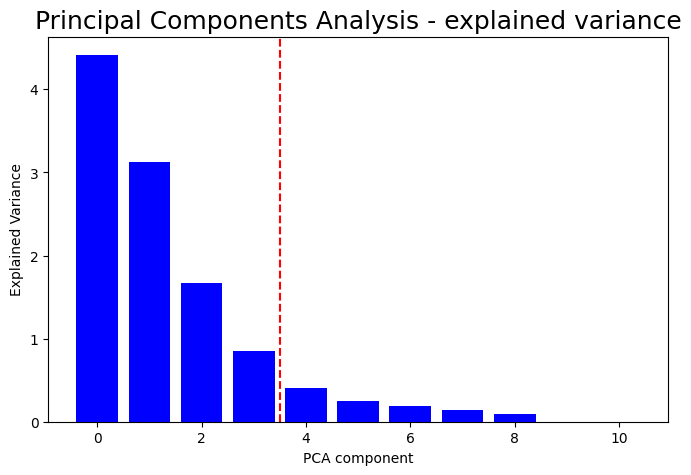

In [31]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.set_title('Principal Components Analysis - explained variance', fontsize=18)
plt.bar(pca_features.index, pca_features['Exp. Variance'], color='blue')
ax.set(
    xlabel = 'PCA component',
    ylabel = 'Explained Variance'
)
plt.axvline(x=3.5, color='red', linestyle='--')
plt.show()

Taking 4th component (3) as a elbow point (get enough information with less dimension) see if we get better results.

In [32]:
n_comp = 4
pca = PCA(n_components=n_comp)
pca_features = pd.DataFrame(pca.fit_transform(scaled_features), index=scaled_features.index,
                           columns=['PCA_' + str(n) for n in range(n_comp)])
pca_features.head()

,PCA_0,PCA_1,PCA_2,PCA_3
region,,,,
Altai Krai,-1.611446,-1.448959,0.671083,-1.084506
Altai Republic,-0.543591,0.746144,0.003934,0.724260
Amur Oblast,-0.756114,-0.688054,-0.189039,-0.146737
Arkhangelsk Oblast,2.448790,1.036180,-1.531210,0.659525
Astrakhan Oblast,-1.297195,-1.764572,0.624814,0.156172


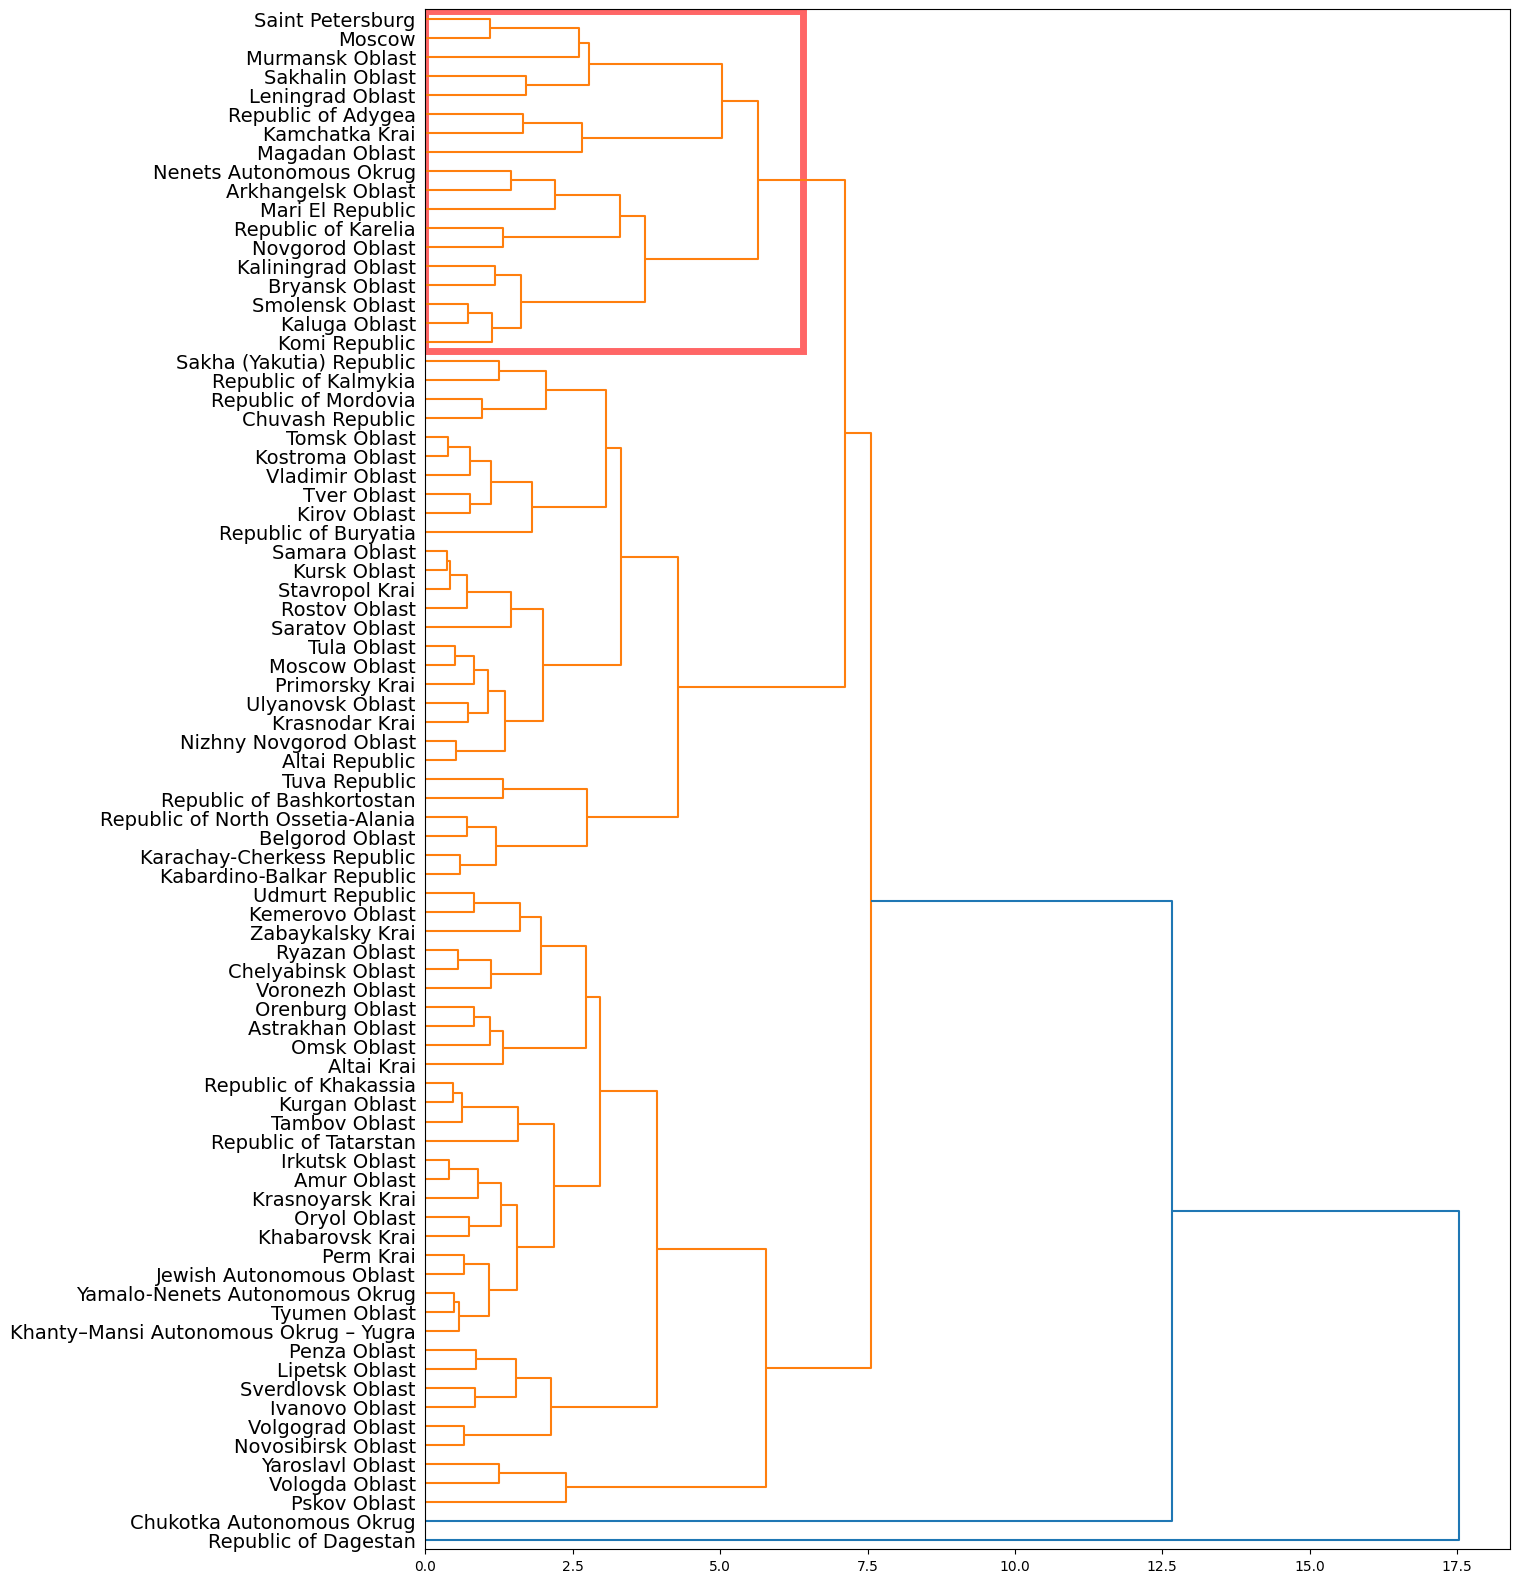

In [33]:
# Proceed the same process
Z = linkage(pca_features, method='complete')

# Plot dendrogram
fig, ax = plt.subplots(figsize=(14, 20))
dn = dendrogram(Z, labels=features_df.index, orientation='right',
                leaf_rotation=0, leaf_font_size=14)
rect = patches.Rectangle((0, 809.0), 6.4, -178.5, linewidth=5, edgecolor='r', 
                         fill=False, facecolor=None, alpha=0.6)
ax.add_patch(rect)
plt.show()

**Conclusions**
- Using the same number of clusters, we identified a bit wider cluster for Saint Petersburg
- Comparing this cluster with the previous one can give us additional insights on the best way to select the right regions.

Reviewing with t-SNE when we know about it ***(soonze for now)***

In [35]:
pca_features['cluster'] = fcluster(Z, 5, criterion='maxclust')

# Set up comparison between 2 clusters
comp_df = pd.DataFrame(index=features_df.index)
comp_df['orig_labels'] = 0
comp_df.loc[features_df.cluster == features_df.loc['Saint Petersburg', 'cluster'], 'orig_labels'] = 1
comp_df['PCA_labels'] = 0
comp_df.loc[pca_features.cluster == pca_features.loc['Saint Petersburg', 'cluster'], 'PCA_labels'] = 1
comp_df = pd.concat([comp_df, features_df.drop('cluster', axis=1)], axis=1)

# Subset relevant columns
cols = ['orig_labels', 'PCA_labels', 'wine', 'wine_shr', 'wine_shr_ptchg', 'beer_shr', 'beer_shr_ptchg']

comp_df = comp_df[comp_df[['orig_labels', 'PCA_labels']].any(axis=1)][cols]
comp_df.sort_values('orig_labels', ascending=False)

,orig_labels,PCA_labels,wine,wine_shr,wine_shr_ptchg,beer_shr,beer_shr_ptchg
region,,,,,,,
Arkhangelsk Oblast,1,1,9.444880,12.610805,-0.601200,63.130469,0.871338
Mari El Republic,1,1,7.910013,15.105553,-1.218593,60.628615,2.314155
Sakhalin Oblast,1,1,7.336412,8.195291,0.594852,67.114749,-1.880275
Saint Petersburg,1,1,7.556872,9.425069,0.573718,74.899617,-0.881005
Republic of Karelia,1,1,11.736149,14.882670,0.344304,62.631417,-0.113553
Novgorod Oblast,1,1,10.911511,14.669453,0.127955,65.010205,0.688998
Nenets Autonomous Okrug,1,1,10.281473,13.174027,-0.290969,61.834055,1.951142
Murmansk Oblast,1,1,8.826371,11.418689,-0.278716,63.822845,-0.056786
Moscow,1,1,7.928479,6.913962,-0.080470,73.064403,0.197307


### 5.5 Comparison of results from 2 clustering methods
- **The same regions are on the intersection of both methods** - we should definitely keep all of those in our short list for prioritizing 10 regions
- Approach with PCA features ended up **expanding the Saint Petersburg cluster to 5 additional regions** - we can review those one by one to see if they are a match with the consumption trends we observed in Saint Petersburg
- **Republic of Adygea** appears to be an outlier - with the same share of wine in consumption, the absolute l per capita is approximately half of benchmark, also St. Petersburg is not suitable for marketing again due to money ...

In [36]:
# Remove Republic of Adygea and Saint Petersburg from candidates
comp_df.drop(['Republic of Adygea', 'Saint Petersburg'], axis=0, inplace=True)

In [37]:
# Determine predicted consumption
comp_df['wine_pred'] = comp_df['wine'] * (1 + comp_df['wine_shr_ptchg'] / comp_df['wine_shr'])
cols = ['wine', 'wine_pred']
regions_final = comp_df[cols].sort_values('wine_pred', ascending=False).reset_index().head(10)
regions_final

,region,wine,wine_pred
0,Republic of Karelia,11.736149,12.007659
1,Novgorod Oblast,10.911511,11.006687
2,Komi Republic,9.956486,10.314312
3,Nenets Autonomous Okrug,10.281473,10.054391
4,Leningrad Oblast,8.471244,9.016361
5,Kaliningrad Oblast,8.222509,9.011776
6,Arkhangelsk Oblast,9.444880,8.994610
7,Smolensk Oblast,8.255440,8.643664
8,Murmansk Oblast,8.826371,8.610930
9,Bryansk Oblast,7.705865,7.900766


### Key takeaways from the ranking of regions
Most of the identified regions are geographically grouped in North-West part of Russia (with exception of Bryansk Oblast and Smolensk Oblast which lean more south as a part of Moscow region). It makes sense that consumer behaviors and preferences are similar in regions adjacent to each other on the map.